In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv('volk_polo_dataset.csv', index_col=0)

In [4]:
df.head()

,new_or_used,двигатель,комплектация,коробка,кузов,налог,онлайн-показ,описание,привод,цвет,...,руль,состояние,таможня,госномер,владение,продаёт собственник,гарантия,на гарантии,проверенный автомобиль,медленно теряет вцене
0,new,1.6 л / 110л.с. / бензин,respect,механическая,лифтбек,2750₽ / год,1.000,хотите получить дополнительную выгоду до 10%? ...,передний,серый,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,new,1.6 л / 110л.с. / бензин,exclusive,автоматическая,лифтбек,2750₽ / год,NaN,——————————————————————————— функциональное обо...,передний,чёрный,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,new,1.6 л / 110л.с. / бензин,respect,механическая,лифтбек,3740₽ / год,NaN,фольксваген центр подольск готов сделать вам п...,передний,белый,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,used,1.6 л / 105л.с. / бензин,NaN,механическая,седан,2625₽ / год,NaN,лот: 01244867 favorit motors kia мкад вы может...,передний,синий,...,левый,не требует ремонта,растаможен,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,new,1.6 л / 110л.с. / бензин,status,автоматическая,лифтбек,2750₽ / год,NaN,выгодные предложения на все комплектации и цве...,передний,коричневый,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
len(df)

640

In [6]:
df.columns

Index(['new_or_used', 'двигатель', 'комплектация', 'коробка', 'кузов', 'налог',
       'онлайн-показ', 'описание', 'привод', 'цвет', 'цена', '1 владелец',
       'vin', 'владельцы', 'год выпуска', 'дтп ненайдены', 'обмен', 'пробег',
       'птс', 'руль', 'состояние', 'таможня', 'госномер', 'владение',
       'продаёт собственник', 'гарантия', 'на гарантии',
       'проверенный автомобиль', 'медленно теряет вцене'],
      dtype='object')

In [7]:
df = df.rename(columns={'владельцы': 'owners', 'год выпуска': 'year_of_release',
                        'двигатель': 'engine', 'коробка': 'transmission',
                        'кузов': 'car_type', 'налог': 'tax', 'привод': 'drive_type',
                        'описание': 'description', 'пробег': 'mileage', 'птс': 'ptc',
                        'руль': 'steering_wheel', 'состояние': 'condition', 
                        'таможня': 'customhouse', 'цвет': 'color', 'цена': 'price',
                        'обмен': 'exchange', 'гарантия': 'guarantee', 'владение': 'ownership',
                        'кузов №': 'body_type_number', 'запас хода': 'capacity reserve',
                        'госномер': 'gos_num', 'кузов №': 'body_nomber', 
                        'дтп ненайдены': 'no_dtp', 'онлайн-показ': 'online_show',
                        '1 владелец': 'one_owner', 'комплектация': 'equipment',
                        'продаёт собственник': 'sells_owner', 'на гарантии': 'on_guarantee',
                        'проверенный автомобиль': 'checked_auto', 'медленно теряет вцене': 'loses_price'})

In [8]:
columns_to_remove = ['engine', 'drive_type', 'one_owner',
                     'vin', 'steering_wheel', 'condition',
                     'gos_num', 'ownership', 'guarantee', 
                     'on_guarantee', 'checked_auto', 'loses_price',
                     'engine_type']

In [9]:
df.columns

Index(['new_or_used', 'engine', 'equipment', 'transmission', 'car_type', 'tax',
       'online_show', 'description', 'drive_type', 'color', 'price',
       'one_owner', 'vin', 'owners', 'year_of_release', 'no_dtp', 'exchange',
       'mileage', 'ptc', 'steering_wheel', 'condition', 'customhouse',
       'gos_num', 'ownership', 'sells_owner', 'guarantee', 'on_guarantee',
       'checked_auto', 'loses_price'],
      dtype='object')

### Take nlp part

In [10]:
nlp_part = df['description']
df = df.drop(columns=['description'])

### Mileage

In [11]:
df.loc[df['new_or_used'] == 'new', 'mileage'] = 0

In [12]:
df['mileage'] = df['mileage'].apply(lambda x: str(x).replace('км', '')).astype('int')

### Engine

In [13]:
def split_engine_be_features(engine_str):
    engine_split = engine_str.split('/')
    
    engine_volume = engine_split[0].strip().split(' ')[0]
    engine_power = engine_split[1].strip().split(' ')[0]
    engine_type = engine_split[2].strip()
    
    return engine_volume, engine_power, engine_type

In [14]:
df['engine_volume'], df['engine_power'], df['engine_type'] = zip(*df['engine'].map(split_engine_be_features))

df['engine_volume'] = df['engine_volume'].astype('float')

df['engine_power'] = df['engine_power'].apply(lambda x: str(x).replace('л.с.', '')).astype('int')
df['engine_power'] = df['engine_power'].astype('int')

### Equipment

In [15]:
df.loc[df['equipment'].isna(), 'equipment'] = 'unknown'

### Tax

In [16]:
df['tax'] = df['tax'].apply(lambda x: x.replace('₽ / год', '')).astype('int')

### Online_show

In [17]:
df.loc[~df['online_show'].isna(), 'online_show'] = True
df.loc[df['online_show'].isna(), 'online_show'] = False

### Car_type

In [18]:
df['car_type'].value_counts()

лифтбек            394
седан              212
хэтчбек 5 дв.       25
хэтчбек 3 дв.        8
универсал 5 дв.      1
Name: car_type, dtype: int64

### 

In [19]:
df['color'].value_counts(normalize=True) < 0.1

белый          False
серый          False
чёрный         False
серебристый    False
синий           True
коричневый      True
красный         True
бежевый         True
жёлтый          True
голубой         True
зелёный         True
золотистый      True
оранжевый       True
Name: color, dtype: bool

### Owners

In [20]:
df.loc[(df['one_owner'] == 1.0) | (df['owners'] == '1владелец'), 'owners'] = '1'
df.loc[df['owners'] == '2владельца', 'owners'] = '2'
df.loc[df['owners'] == '3 или более', 'owners'] = '3+'
df.loc[df['new_or_used'] == 'new', 'owners'] = '0'

### Year_of_release

In [21]:
df.loc[(df['new_or_used'] == 'new') & (df['year_of_release'].isna()), 'year_of_release'] = '2021'

In [22]:
df['year_of_release'] = df['year_of_release'].astype('int')

### No_dtp

In [23]:
df.loc[(df['new_or_used'] == 'new') & (df['no_dtp'].isna()), 'no_dtp'] = 1.0

In [24]:
df['no_dtp'].value_counts(dropna=False)

1.000    509
NaN      131
Name: no_dtp, dtype: int64

In [25]:
df['no_dtp'] = df['no_dtp'].apply(lambda x: 'true' if x == 1.0 else 'unknown')

In [26]:
df['no_dtp'].value_counts()

true       509
unknown    131
Name: no_dtp, dtype: int64

### Exchange

In [27]:
df['exchange'].value_counts(dropna=False)

NaN                   554
рассмотрю варианты     86
Name: exchange, dtype: int64

In [28]:
df['exchange'] = df['exchange'].apply(lambda x: True if pd.notna(x) else False)

In [29]:
df['exchange'].value_counts(dropna=False)

False    554
True      86
Name: exchange, dtype: int64

### Ptc

In [30]:
df['ptc'].value_counts(dropna=False)

NaN         381
оригинал    234
дубликат     25
Name: ptc, dtype: int64

In [31]:
df.loc[(df['ptc'].isna()) & (df['new_or_used'] == 'new'), 'ptc'] = 'новая машина'

### Customhouse

In [32]:
df['customhouse'].value_counts(dropna=False)

NaN           381
растаможен    259
Name: customhouse, dtype: int64

In [33]:
df.loc[(df['customhouse'].isna()) & (df['new_or_used'] == 'new'), 'customhouse'] = 'не растаможен'

In [34]:
df['customhouse'].value_counts(dropna=False)

не растаможен    381
растаможен       259
Name: customhouse, dtype: int64

### Sells_owner

In [35]:
df['sells_owner'].value_counts(dropna=False)

NaN      604
1.000     36
Name: sells_owner, dtype: int64

In [36]:
df.loc[(df['sells_owner'].isna()) & (df['new_or_used'] == 'new'), 'sells_owner'] = 'новая машина'
df.loc[(df['sells_owner'].isna()) & (df['new_or_used'] != 'new'), 'sells_owner'] = 'false'
df.loc[df['sells_owner'] == 1.0, 'sells_owner'] = 'true'

In [37]:
df['sells_owner'].value_counts(dropna=False)

новая машина    381
false           223
true             36
Name: sells_owner, dtype: int64

In [38]:
df = df.drop(columns=columns_to_remove)

In [39]:
cols_with_incorrect_low_values = ['car_type', 'color', 'engine_volume', 'engine_power']
for col in cols_with_incorrect_low_values:
    values_above = df[col].value_counts().loc[df[col].value_counts(normalize=True) < 0.01].index
    df = df[~df[col].isin(values_above)]

In [40]:
df.nunique()

new_or_used          2
equipment            5
transmission         3
car_type             4
tax                 21
online_show          2
color               10
price              391
owners               4
year_of_release     14
no_dtp               2
exchange             2
mileage            205
ptc                  3
customhouse          2
sells_owner          3
engine_volume        3
engine_power         5
dtype: int64

### Concert categorical and numeric features

In [41]:
categorical_features = ['new_or_used', 'equipment', 'transmission',
                        'car_type', 'online_show', 'color', 'owners',
                        'no_dtp', 'exchange', 'ptc', 'customhouse',
                        'sells_owner', 'engine_volume', 'engine_power']

numeric_features = ['tax', 'year_of_release', 'mileage']

In [42]:
df = pd.get_dummies(data=df, columns=categorical_features, drop_first=True)

In [43]:
for num_feature in numeric_features:
    df[num_feature] = df[num_feature].astype('int')

In [44]:
df['price'] = df['price'].apply(lambda x: x.split(' ')[-1].replace('₽', '').strip()).astype('int')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 615 entries, 0 to 639
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   tax                            615 non-null    int64
 1   price                          615 non-null    int64
 2   year_of_release                615 non-null    int64
 3   mileage                        615 non-null    int64
 4   new_or_used_used               615 non-null    uint8
 5   equipment_origin               615 non-null    uint8
 6   equipment_respect              615 non-null    uint8
 7   equipment_status               615 non-null    uint8
 8   equipment_unknown              615 non-null    uint8
 9   transmission_механическая      615 non-null    uint8
 10  transmission_роботизированная  615 non-null    uint8
 11  car_type_седан                 615 non-null    uint8
 12  car_type_хэтчбек 3 дв.         615 non-null    uint8
 13  car_type_хэтчбек 5 д

### Drop NA

In [46]:
df = df.dropna(how='any')

### Split data

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price']),
                                                    df['price'], 
                                                    test_size=0.25)

In [48]:
X_train.shape, X_test.shape

((461, 39), (154, 39))

### Scaling

In [49]:
scaler_x = MinMaxScaler()
X_train[numeric_features] = scaler_x.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler_x.transform(X_test[numeric_features])

## Modeling

### BaseLine

In [50]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats

In [51]:
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
RMSE
R2
MAPE


In [52]:
median_train = y_train.median()
baseline = np.array([median_train] * len(y_test))
measured_metrics['baseline'] = dataframe_metrics(y_test, baseline)
measured_metrics

,error_type,baseline
0,MAE,288106.338
1,RMSE,365841.236
2,R2,-0.228
3,MAPE,54.753


### Linear Reg

In [53]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

LinearRegression()

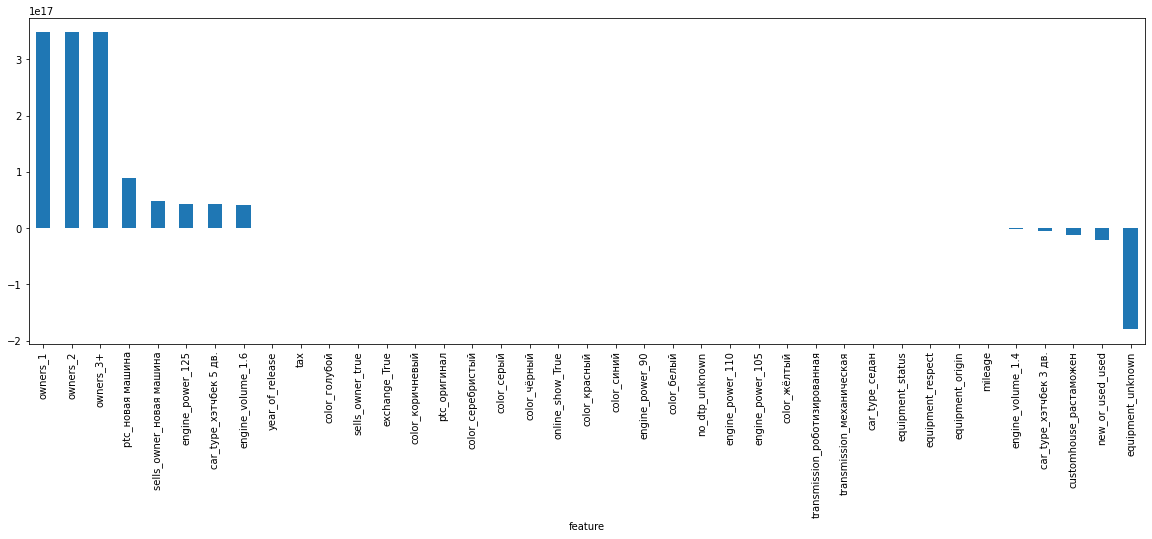

In [54]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": lin_reg.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(20, 6));

In [55]:
predictions = lin_reg.predict(X_test)

In [56]:
measured_metrics["lin_reg"] = dataframe_metrics(y_test, predictions)
measured_metrics

,error_type,baseline,lin_reg
0,MAE,288106.338,597928367152925.250
1,RMSE,365841.236,5158379713272574.000
2,R2,-0.228,-244082937686572269568.000
3,MAPE,54.753,165338879610.507


In [57]:
df[['price']].describe()

,price
count,615.000
mean,899959.559
std,303087.647
min,295000.000
25%,520000.000
50%,1000000.000
75%,1125300.000
max,1352300.000


## RidgeCV

In [58]:
ridge_cv = RidgeCV()

ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

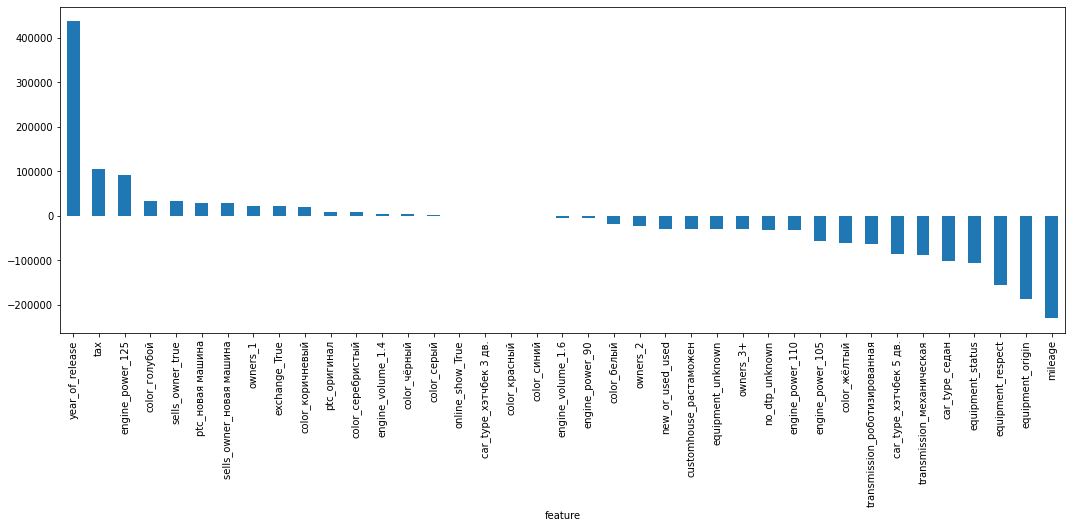

In [59]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": ridge_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(18, 6));

In [60]:
predictions = ridge_cv.predict(X_test)
measured_metrics["ridge_cv"] = dataframe_metrics(y_test, predictions)
measured_metrics

,error_type,baseline,lin_reg,ridge_cv
0,MAE,288106.338,597928367152925.250,57475.322
1,RMSE,365841.236,5158379713272574.000,72594.380
2,R2,-0.228,-244082937686572269568.000,0.952
3,MAPE,54.753,165338879610.507,7.780


## LassoCV

In [61]:
lasso_cv = LassoCV()

lasso_cv.fit(X_train, y_train)

LassoCV()

,error_type,baseline,lin_reg,ridge_cv,lasso_cv
0,MAE,288106.338,597928367152925.250,57475.322,57186.136
1,RMSE,365841.236,5158379713272574.000,72594.380,72443.244
2,R2,-0.228,-244082937686572269568.000,0.952,0.952
3,MAPE,54.753,165338879610.507,7.780,7.684


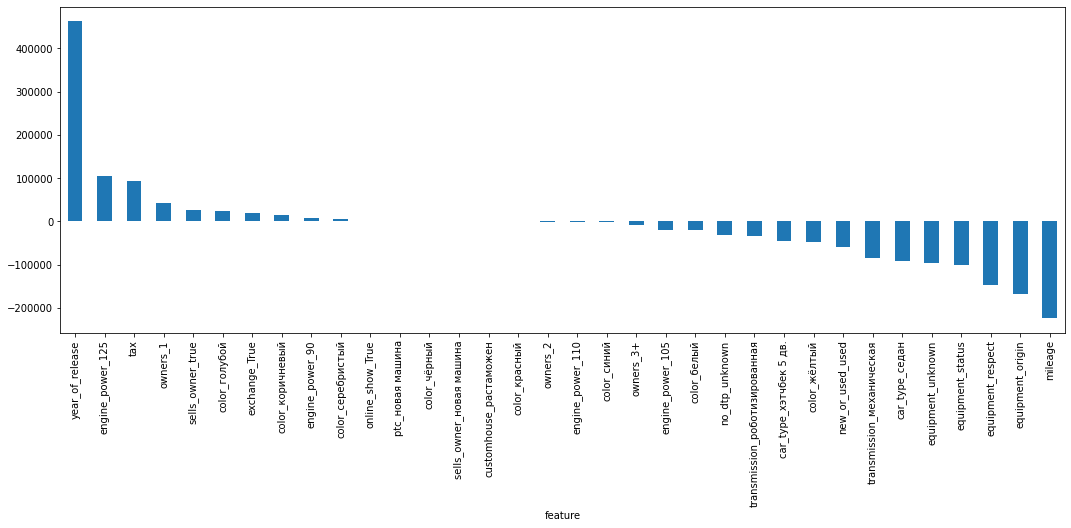

In [62]:
featureImportance = pd.DataFrame({"feature": X_train.columns[lasso_cv.coef_!=0], 
                                  "importance": lasso_cv.coef_[lasso_cv.coef_!=0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(18, 6));

measured_metrics["lasso_cv"] = dataframe_metrics(y_test, lasso_cv.predict(X_test))
measured_metrics

### Random Forest

In [63]:
rf_reg = RandomForestRegressor(n_jobs=-1)
rf_reg.fit(X_train, y_train)

measured_metrics["rf_reg"] = dataframe_metrics(y_test, rf_reg.predict(X_test))
measured_metrics

,error_type,baseline,lin_reg,ridge_cv,lasso_cv,rf_reg
0,MAE,288106.338,597928367152925.250,57475.322,57186.136,48515.113
1,RMSE,365841.236,5158379713272574.000,72594.380,72443.244,64345.265
2,R2,-0.228,-244082937686572269568.000,0.952,0.952,0.962
3,MAPE,54.753,165338879610.507,7.780,7.684,6.300


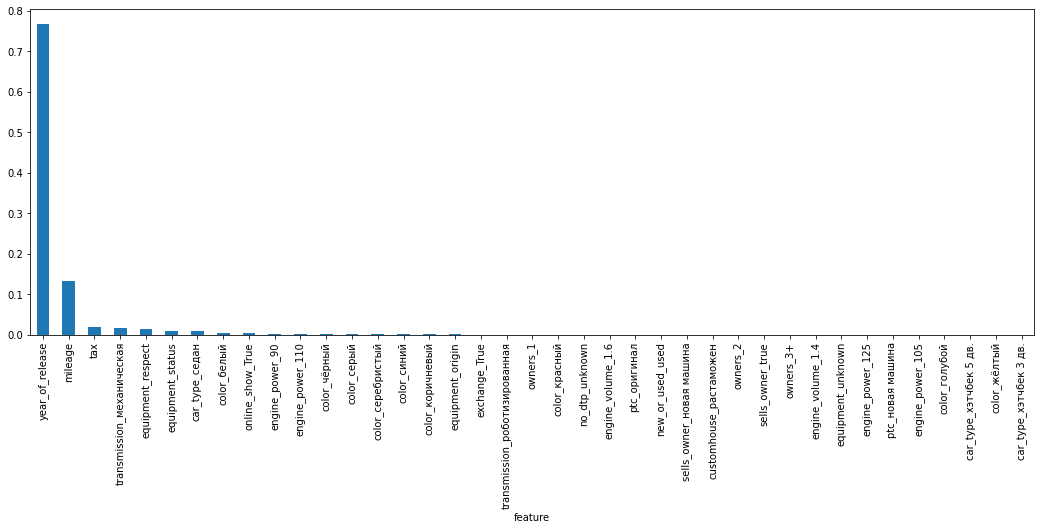

In [64]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": rf_reg.feature_importances_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(18, 6));